In [1]:
suppressPackageStartupMessages(library(ggExtra))
suppressPackageStartupMessages(library(textclean))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))

In [2]:
fubar_output <- data.table::fread('data/selective_landscape/2022-09_hyphy_fubar_output.csv', stringsAsFactors = FALSE) %>%
    mutate(gene = if_else(gene=="S", "Spike", gene)) %>%
    mutate(protein = if_else(protein=="S", "Spike", protein)) %>%
    arrange(gene, site) 


In [3]:
################################
# LOAD IN MUTATIONS PER GENOME #
################################
HFV_threshold <- minimum_obs <- 10000

orf1ab_tbl <- data.table::fread("data/ORF1a__ORF1b_CDS.curated.csv", stringsAsFactors = FALSE)
orf1ab_tbl[11:16,]$Product <- substr(orf1ab_tbl$Note[11:16], 0, 5)

# Get unique set of Spike Mutations
all_mutation_list <- data.table::fread("~/efs_shared/COVID19/Mutations in min 1000 - 2022-11-17.csv", stringsAsFactors = FALSE) %>%
    dplyr::rename(Protein = protein)

cat(paste0(format(all_mutation_list %>% filter(count > HFV_threshold) %>% nrow(), big.mark=","), " unique mutations with ", HFV_threshold, "+ sequences\n"))

1,154 unique mutations with 10000+ sequences


## Read in T-Cell Epitope tables and Annotate

In [4]:
cd4_ts1_table <- data.table::fread("data/tcell_epitopes/Mateus_TableS1_annotated.csv", stringsAsFactors = FALSE) %>% 
        mutate(source = "CD4 - SARS-CoV-2-naïve Individuals")

cd8_COVID_ts1_table <- data.table::fread("data/tcell_epitopes/Saini_TableS4_COVID19_annotated.csv", stringsAsFactors = FALSE) %>% 
        mutate(source = "CD8 - Recovered COVID Patients")

cd8_healthy_ts1_table <- rbind(
    data.table::fread("data/tcell_epitopes/Saini_TableS7a_healthy_annotated.csv", stringsAsFactors = FALSE),
    data.table::fread("data/tcell_epitopes/Saini_TableS7b_healthy_annotated.csv", stringsAsFactors = FALSE)
) %>% mutate(source = "CD8 - SARS-CoV-2-naïve Individuals")


In [5]:
ts1_table_1b <- rbind(
        cd4_ts1_table %>% dplyr::select(source, Gene, Protein, gene_start, gene_stop, protein_start),
        cd8_healthy_ts1_table %>% dplyr::select(source, Gene, Protein, gene_start, gene_stop, protein_start), 
        cd8_COVID_ts1_table %>% dplyr::select(source, Gene, Protein, gene_start, gene_stop, protein_start)
    ) %>%
    mutate(
        sequence_len = gene_stop - gene_start + 1,
        
        intersection_len = sapply(paste0(Protein, "_", protein_start, "/", sequence_len), function(x){
            selected_protein = gsub("[_].*$", "", x)
            selected_site = as.numeric(gsub("^.*[_]|[/].*$", "", x))
            len = as.numeric(gsub("^.*[/]", "", x))
            selected_site_range <- selected_site:(selected_site+len-1)
            
            tmp <- all_mutation_list %>%
                filter(
                    count >= HFV_threshold &
                    Protein == selected_protein &
                    site %in% selected_site_range
                ) %>%
                filter(!duplicated(site)) %>%
                nrow()
            
            if(length(tmp) > 0){
                return(tmp)
            }
            return(NA)
        }),
        
        `Sites Under Diversifying Selection` = sapply(paste0(Gene, "_", gene_start, "/", sequence_len), function(x){
            selected_gene = gsub("[_].*$", "", x)
            selected_site = as.numeric(gsub("^.*[_]|[/].*$", "", x))
            len = as.numeric(gsub("^.*[/]", "", x))
            selected_site_range <- selected_site:(selected_site+len-1)

            tmp <- fubar_output %>%
                filter(
                    gene == selected_gene &
                    site %in% selected_site_range &
                    `Prob[alpha<beta]` > 0.9
                ) %>%
                nrow()
            
            if(length(tmp) > 0){
                return(tmp)
            }
            return(NA)
        }),
        
        `Sites Under Purifying Selection` = sapply(paste0(Gene, "_", gene_start, "/", sequence_len), function(x){
            selected_gene = gsub("[_].*$", "", x)
            selected_site = as.numeric(gsub("^.*[_]|[/].*$", "", x))
            len = as.numeric(gsub("^.*[/]", "", x))
            selected_site_range <- selected_site:(selected_site+len-1)

            tmp <- fubar_output %>%
                filter(
                    gene == selected_gene &
                    site %in% selected_site_range &
                    `Prob[alpha>beta]` > 0.9
                ) %>%
                nrow()
            
            if(length(tmp) > 0){
                return(tmp)
            }
            return(NA)
        }),
        `Sites Under Selection` = `Sites Under Diversifying Selection` + `Sites Under Purifying Selection`
    ) %>%
    mutate(
        source = factor(source, levels = c("CD4 - SARS-CoV-2-naïve Individuals", "CD8 - SARS-CoV-2-naïve Individuals", "CD8 - Recovered COVID Patients"))
    )

# Variants per epitope

### Main Figures

Warning message:
“Removed 20 rows containing missing values (geom_bar).”


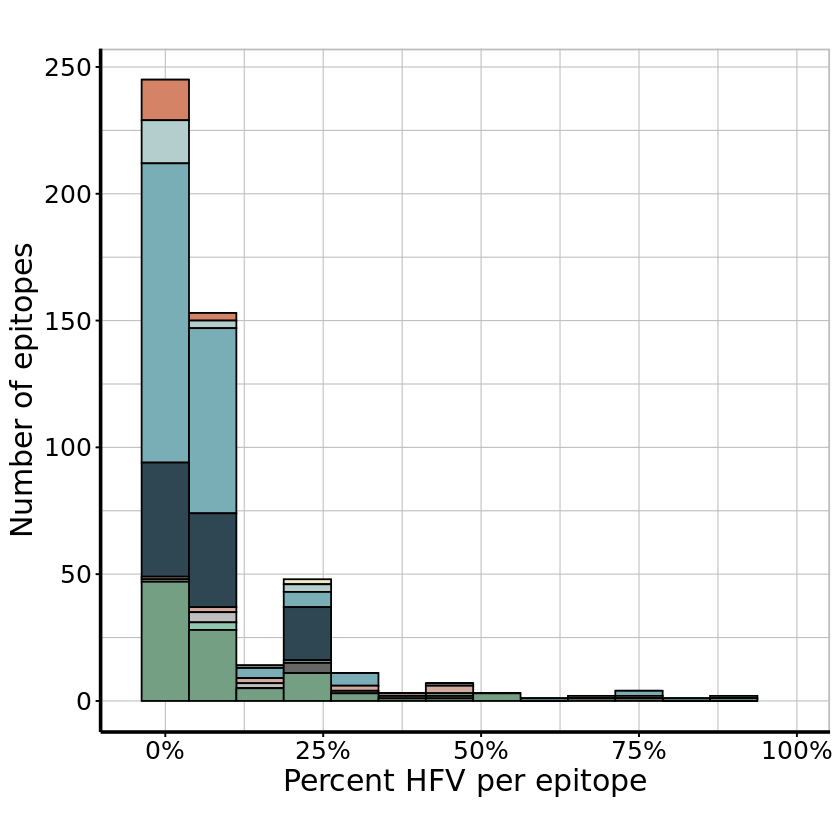

In [7]:
figure4a <- ts1_table_1b %>% 
    filter(source == "CD8 - SARS-CoV-2-naïve Individuals") %>%
    mutate(
        intersection_len = intersection_len / sequence_len
    ) %>%
    gghistogram(
        x = "intersection_len" , 
        fill = "Gene",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent HFV per epitope\n", y = "Number of epitopes") +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "none", 

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )  +
    scale_fill_manual(values=rev(c(
        Spike="#749f82",
        ORF1a = "#7aaeb6",
        ORF1b = "#2f4653",                               
        N =  "lightcyan3",
        ORF7a = "#90c7ae", 
        M = "#d48367",
        ORF3a = "#D3AB9E",
        E = "lemonchiffon2",
        ORF6 = "grey",
        ORF8 = "grey40"
    )),name="") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1))


figure4a


Warning message:
“Removed 20 rows containing missing values (geom_bar).”


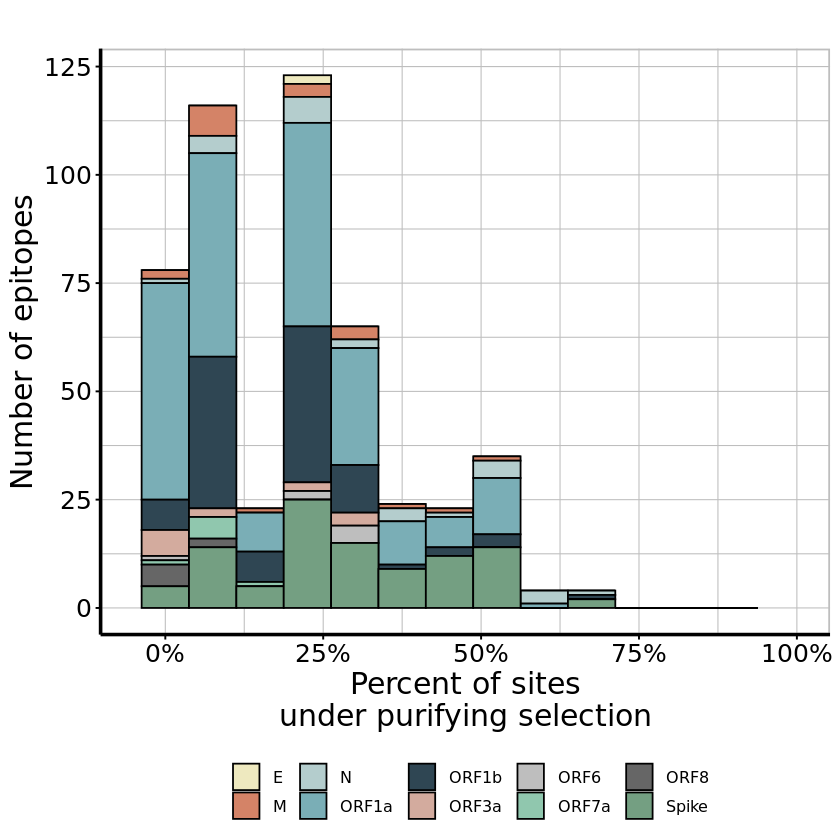

In [8]:
figure4b <- ts1_table_1b %>% 
    filter(source == "CD8 - SARS-CoV-2-naïve Individuals") %>%
    mutate(
        Var1 = `Sites Under Purifying Selection` / sequence_len,
    ) %>%
    gghistogram(
        x = "Var1" , 
        fill = "Gene",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent of sites\nunder purifying selection", y = "Number of epitopes") +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )  +
    scale_fill_manual(values=rev(c(
        Spike="#749f82",
        ORF1a = "#7aaeb6",
        ORF1b = "#2f4653",                               
        N =  "lightcyan3",
        ORF7a = "#90c7ae", 
        M = "#d48367",
        ORF3a = "#D3AB9E",
        E = "lemonchiffon2",
        ORF6 = "grey",
        ORF8 = "grey40"
    )),name="") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1))

figure4b

Warning message:
“Removed 20 rows containing missing values (geom_bar).”


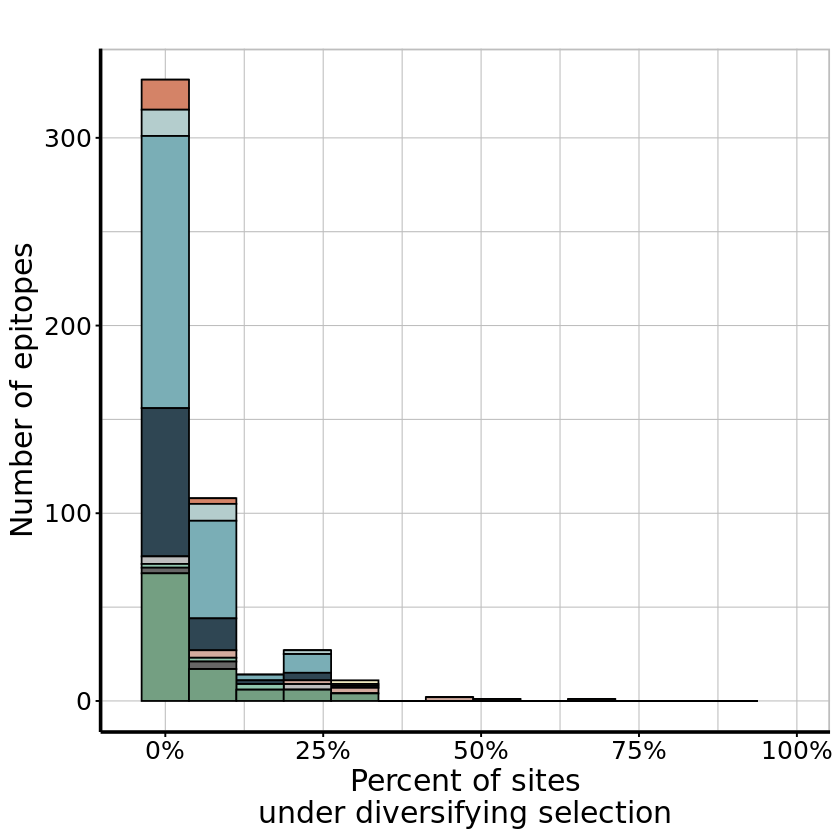

In [9]:
figure4c <- ts1_table_1b %>% 
    filter(source == "CD8 - SARS-CoV-2-naïve Individuals") %>%
    mutate(
        Var1 = `Sites Under Diversifying Selection` / sequence_len,
    ) %>%
    gghistogram(
        x = "Var1" , 
        fill = "Gene",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent of sites\nunder diversifying selection", y = "Number of epitopes") +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "none", # "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )  +
    scale_fill_manual(values=rev(c(
        Spike="#749f82",
        ORF1a = "#7aaeb6",
        ORF1b = "#2f4653",                               
        N =  "lightcyan3",
        ORF7a = "#90c7ae", 
        M = "#d48367",
        ORF3a = "#D3AB9E",
        E = "lemonchiffon2",
        ORF6 = "grey",
        ORF8 = "grey40"
    )),name="") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1))

figure4c

Warning message:
“Removed 4 rows containing missing values (geom_bar).”


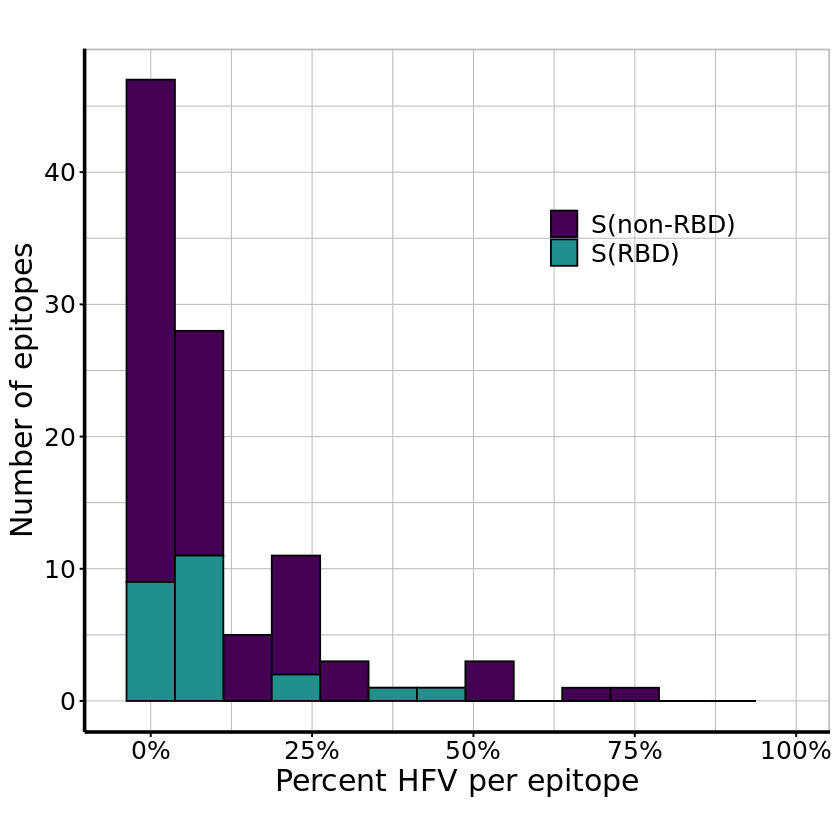

In [10]:
# Running with richards code
py <- seq( 0 , 40, 5 )

figure4d <- ts1_table_1b %>% 
    filter(source == "CD8 - SARS-CoV-2-naïve Individuals") %>%
    filter(Gene == "Spike") %>%
    mutate(
        Protein = case_when(
            Gene == "Spike" & gene_start >= 319 & gene_stop <= 541 ~ "S(RBD)",
            Gene == "Spike" ~ "S(non-RBD)"
        ),
        intersection_len = intersection_len / sequence_len
    ) %>%
    gghistogram(
        x = "intersection_len" , 
        fill = "Protein",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent HFV per epitope\n ", y = "Number of epitopes") +
    scale_fill_manual(values=viridisLite::viridis(3),name="") + 
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.text = element_text(size=15),
        legend.background = element_rect(fill=NA, color = NA, size=2, linetype=1),
        legend.position = c(0.75, 0.75),#"bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )+
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1))

figure4d

Warning message:
“Removed 3 rows containing missing values (geom_bar).”


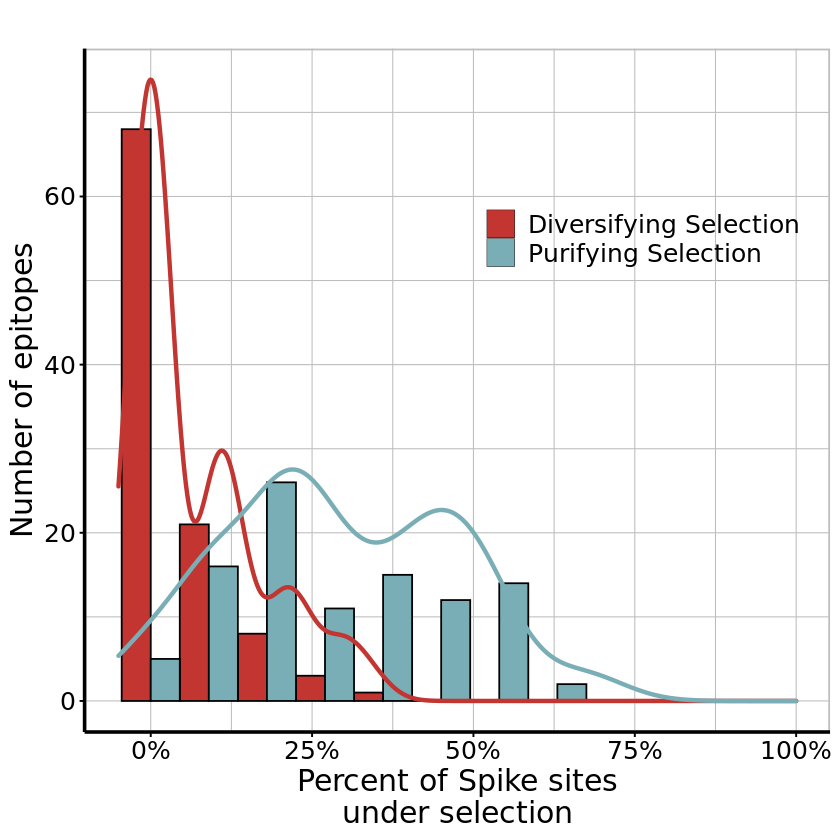

In [11]:
figure4e <- rbind(
    ts1_table_1b %>%
        filter(Gene == "Spike") %>%
        mutate(
            Var1 = `Sites Under Diversifying Selection` / sequence_len,
            Type = "Diversifying Selection"
        ),
    ts1_table_1b %>%
        filter(Gene == "Spike") %>%
        mutate(
            Var1 = `Sites Under Purifying Selection` / sequence_len,
            Type = "Purifying Selection"
        )
    ) %>%
    filter(source == "CD8 - SARS-CoV-2-naïve Individuals") %>%
    mutate(
        Type = factor(Type, levels = (c("Diversifying Selection", "Purifying Selection")))
    ) %>%
    gghistogram(
        x = "Var1" , 
        fill = "Type",
        binwidth = 0.09,
        color = "black", 
        position = "dodge", 
        alpha = 1
    )  +
    geom_density(
        aes(y = ..count..^.75 / 2.25, color = Type),
        size = 1.25
    ) +
    labs(title = "", x = "Percent of Spike sites\nunder selection", y = "Number of epitopes") +
    scale_color_manual(values=rev(c("#7aaeb6","#c23531")),name="") + 
    scale_fill_manual(values=rev(c("#7aaeb6","#c23531")),name="") + 
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.text = element_text(size=15),
        legend.background = element_rect(fill=NA, color = NA, size=2, linetype=1),
        legend.position = c(0.75, 0.75),#"bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )+
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1))

figure4e

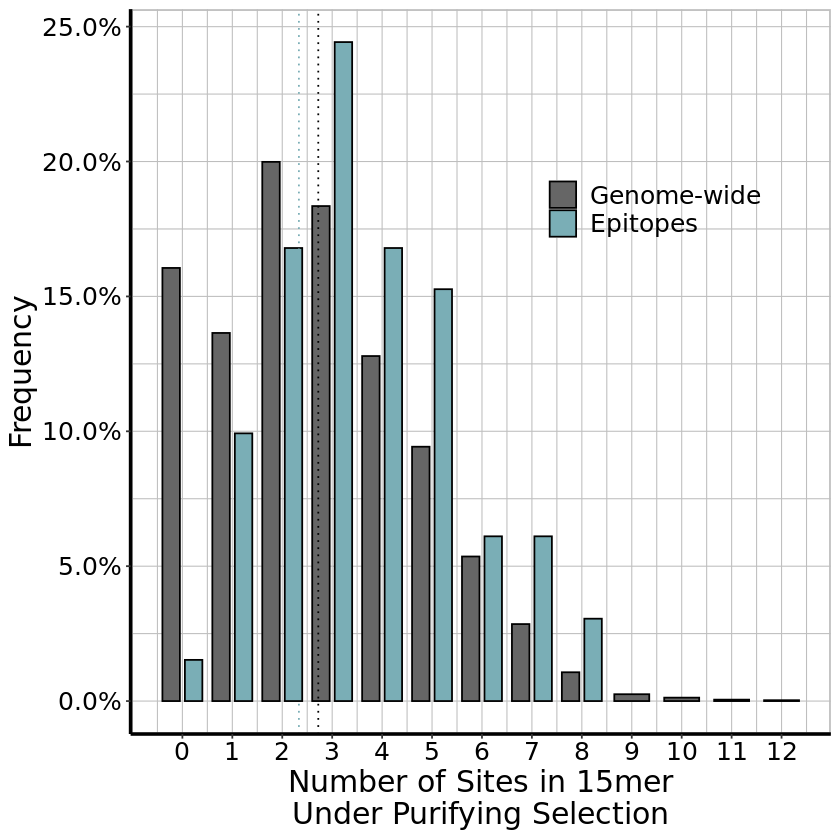

In [12]:
gene_list = all_mutation_list %>% pull(Protein) %>% unique()

protein_lengths_df <- all_mutation_list %>%
    arrange(desc(site)) %>%
    filter(!duplicated(Protein)) %>%
    rename(
        length = site
    ) %>% 
    select(Protein, length)

gene_lengths_df <- protein_lengths_df %>% 
    mutate(
        Gene = case_when(
            !(Protein %in% orf1ab_tbl$Product) ~ Protein,
            Protein %in% (orf1ab_tbl %>% filter(score == "ORF1a") %>% pull(Product)) ~ "ORF1a",
            Protein %in% (orf1ab_tbl %>% filter(score == "ORF1b") %>% pull(Product)) ~ "ORF1b"
        )
    ) %>%
    group_by(Gene) %>%
    summarise(
        length = sum(length)
    )

gene_list = unique(ts1_table_1b$Gene)

all_gene_variant_counts <- all_gene_purifying_selection_counts <- all_gene_positive_selection_counts <- list()
for(this_gene in gene_list){
    gene_length <- gene_lengths_df %>% filter(Gene == this_gene) %>% pull(length) %>% sum()

    all_locations <- seq(1, gene_length-15, by=1)
                                             
    all_gene_purifying_selection_counts[[this_gene]] <- sapply(all_locations, function(loc){
        fubar_output %>%
            filter(
                gene == this_gene &
                site >= loc &
                site < loc + 15 &
                `Prob[alpha>beta]` >= 0.9
            ) %>%
            nrow()
    })
    
     all_gene_positive_selection_counts[[this_gene]] <- sapply(all_locations,function(loc){
         fubar_output %>%
            filter(
                gene == this_gene &
                site >= loc &
                site < loc + 15 &
                `Prob[alpha<beta]` >= 0.9
            ) %>%
            nrow()
     })
}


figure4f_data <- rbind(
        data.table(
            Site = "Epitopes",
            nS = ts1_table_1b %>% filter(source == "CD4 - SARS-CoV-2-naïve Individuals") %>% pull(`Sites Under Purifying Selection`)
        ),
        data.table(
            Site = "Genome-wide",
            nS = unlist(all_gene_purifying_selection_counts)
        )
    )%>%
    mutate(Site = factor(Site,levels=c("Genome-wide","Epitopes"))) %>%
    count(Site, nS)

figure4f <- figure4f_data %>%
    mutate(
        frequency = case_when(
            Site == "Genome-wide" ~ n/sum(figure4f_data %>% filter(Site=="Genome-wide") %>% pull(n)),
            Site == "Epitopes" ~ n/sum(figure4f_data %>% filter(Site=="Epitopes") %>% pull(n))
        ),
        Site = factor(Site,levels=c("Genome-wide","Epitopes"))
    ) %>%
    ggbarplot(
        x="nS",
        y="frequency",
        fill="Site",
        position = position_dodge(0.9)
    ) +
    labs(
        x = "Number of Sites in 15mer\nUnder Purifying Selection",
        y = "Frequency"
    ) +
    scale_fill_manual(values = c("grey40","#7aaeb6"),name="") +
    geom_vline(xintercept = mean(ts1_table_1b$`Sites Under Purifying Selection`),color="#7aaeb6",linetype="dotted")+
    geom_vline(xintercept = mean(unlist(all_gene_purifying_selection_counts)),color="black",linetype="dotted") + 
    scale_x_continuous(breaks=seq(0,max(unlist(all_gene_purifying_selection_counts)),by=1)) +
    theme_bw() +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), 
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.text = element_text(size=15),
        legend.background = element_rect(fill=NA, color = NA, size=2, linetype=1),
        legend.position = c(0.75, 0.75),

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),

        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    ) + 
    scale_y_continuous(labels = scales::percent)

figure4f

### Stats

In [13]:
ts1_table_1b %>% 
    mutate(
        intersection_len = intersection_len / sequence_len
    ) %>%
    group_by(source) %>%
    summarise(
        median(intersection_len),
        mean(intersection_len)
    )

cat("\n\nSpike")
ts1_table_1b %>% 
    filter(
        Gene == "Spike" 
    ) %>% 
    mutate(
        intersection_len = intersection_len / sequence_len
    ) %>%
    group_by(source) %>%
    summarise(
        median(intersection_len),
        mean(intersection_len)
    )


cat("\n\nRBD")
ts1_table_1b %>% 
    filter(
        Gene == "Spike" &
        gene_start >= 319 &
        gene_start < 541
    ) %>% 
    mutate(
        intersection_len = intersection_len / sequence_len
    ) %>%
    group_by(source) %>%
    summarise(
        median(intersection_len),
        mean(intersection_len)
    )

source,median(intersection_len),mean(intersection_len)
<fct>,<dbl>,<dbl>
CD4 - SARS-CoV-2-naïve Individuals,0.06666667,0.12366412
CD8 - SARS-CoV-2-naïve Individuals,0.09090909,0.09455107
CD8 - Recovered COVID Patients,0.10000000,0.11016325




Spike

source,median(intersection_len),mean(intersection_len)
<fct>,<dbl>,<dbl>
CD4 - SARS-CoV-2-naïve Individuals,0.06666667,0.11515152
CD8 - SARS-CoV-2-naïve Individuals,0.10000000,0.10722822
CD8 - Recovered COVID Patients,0.04545455,0.08336139




RBD

source,median(intersection_len),mean(intersection_len)
<fct>,<dbl>,<dbl>
CD4 - SARS-CoV-2-naïve Individuals,0.06666667,0.12666667
CD8 - SARS-CoV-2-naïve Individuals,0.09545455,0.09978956
CD8 - Recovered COVID Patients,0.00000000,0.02272727


In [20]:
#selected_protein <- "nsp7"
selected_protein <- "ORF3a"

#selected_source <- "CD8 - Recovered COVID Patients"
selected_source <- "CD8 - SARS-CoV-2-naïve Individuals"

HFV_sites <- all_mutation_list %>%
    filter(
        count >= HFV_threshold &
        Protein == selected_protein
    ) %>%
    pull(site) %>%
    unique()

selected_peptides <- ts1_table_1b  %>%
    mutate(
        intersection_len = intersection_len / sequence_len
    ) %>%
    filter(
        source == selected_source &
        Protein == selected_protein
    )
selected_peptides$pep_positions <- sapply(1:nrow(selected_peptides), function(i){paste(selected_peptides$protein_start[i]:(selected_peptides$protein_start[i] + selected_peptides$sequence_len[i] - 1), collapse=",")})

HFV_peptides <- selected_peptides %>% filter(grepl(paste0(",", paste(HFV_sites, collapse = ",|,"), ","), pep_positions))

pep_sites <- selected_peptides %>%
    pull(pep_positions) %>%
    strsplit(",") %>% 
    unlist() %>%
    unique()

pos_selected_sites <-  fubar_output %>% 
    filter(
        protein == selected_protein &
        `Prob[alpha<beta]` >= 0.9
    ) %>% 
    pull(site) 

neg_selected_sites <-  fubar_output %>% 
    filter(
        protein == selected_protein &
        `Prob[alpha>beta]` >= 0.9
    ) %>% 
    pull(site) 

protein_len <-  fubar_output %>% 
    filter(protein == selected_protein) %>% 
    pull(site) %>% 
    max()

cat(
    paste0(
        "HFV sites in protein: ", 
        length(HFV_sites), " / ", protein_len, " (",
        round(length(HFV_sites) / protein_len, 2) * 100, "%)\n",
        "HFV peptide sites: ", 
        length(intersect(HFV_sites, pep_sites)), " / ", length(pep_sites), " (", 
        round(length(intersect(HFV_sites, pep_sites)) / length(pep_sites), 2) * 100 , "%)\n",
        "HFV peptides: ",
        nrow(HFV_peptides), " / ", nrow(selected_peptides), " (",
        round(nrow(HFV_peptides) / nrow(selected_peptides), 2) * 100, "%)\n",
        "Peptide sites under positive selection: ", 
        length(intersect(pos_selected_sites, pep_sites)), " / ", length(pep_sites), " (", 
        round(length(intersect(pos_selected_sites, pep_sites)) / length(pep_sites), 2) * 100 , "%)\n",
        "Peptide sites under purifying selection: ", 
        length(intersect(neg_selected_sites, pep_sites)), " / ", length(pep_sites), " (", 
        round(length(intersect(neg_selected_sites, pep_sites)) / length(pep_sites), 2) * 100 , "%)\n"
    )
)


HFV sites in protein: 79 / 276 (29%)
HFV peptide sites: 27 / 80 (34%)
HFV peptides: 12 / 13 (92%)
Peptide sites under positive selection: 22 / 80 (28%)
Peptide sites under purifying selection: 10 / 80 (12%)


### Supplemental Figures

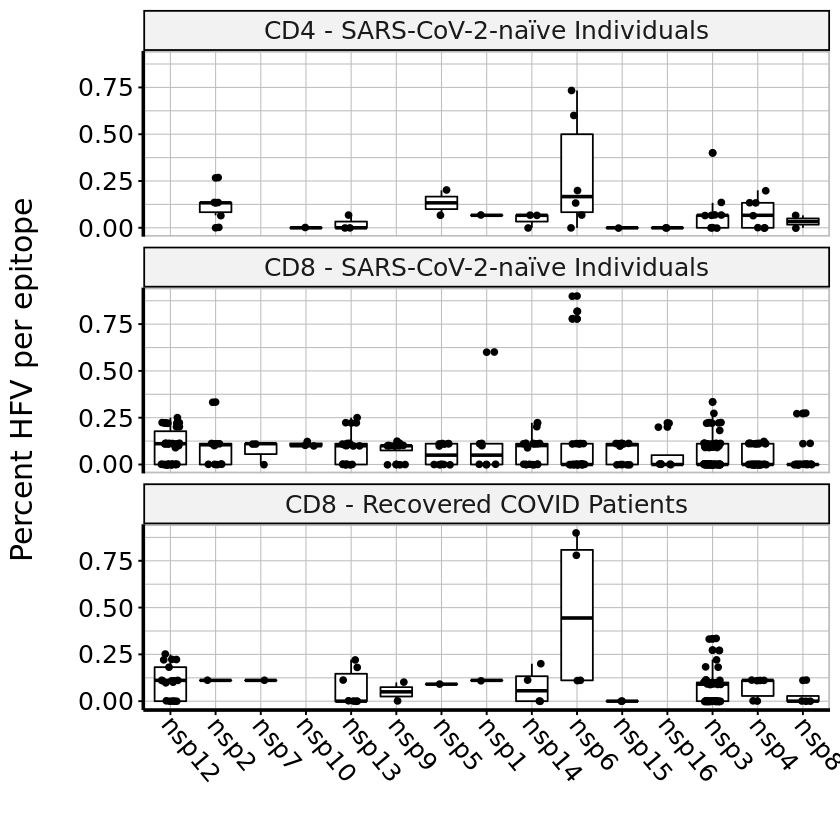

In [21]:
figS4b <- ts1_table_1b %>% 
    filter((Gene %in% c("ORF1a", "ORF1b")) & !(Protein %in% c("ORF1a", "ORF1b"))) %>%
    mutate(
        intersection_len = intersection_len / sequence_len,
        Protein = factor(
            Protein,
            levels = unique(c(
                ts1_table_1b %>% 
                mutate(
                    intersection_len = intersection_len / sequence_len
                ) %>%
                group_by(Protein) %>%
                summarise(
                    x = median(intersection_len),
                    y = sum(intersection_len)
                ) %>%
                arrange(desc(x)) %>% 
                pull(Protein)
            ))
        )
    ) %>%
    ggboxplot(
        x = "Protein",
        y = "intersection_len",
        add = "jitter"
    ) +
    facet_wrap(source~., ncol = 1) +
    labs(
        x = "",
        y = "Percent HFV per epitope\n"
    ) +
    theme( 
        axis.text.x = element_text(size= 15, colour = "black" ,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )

figS4b

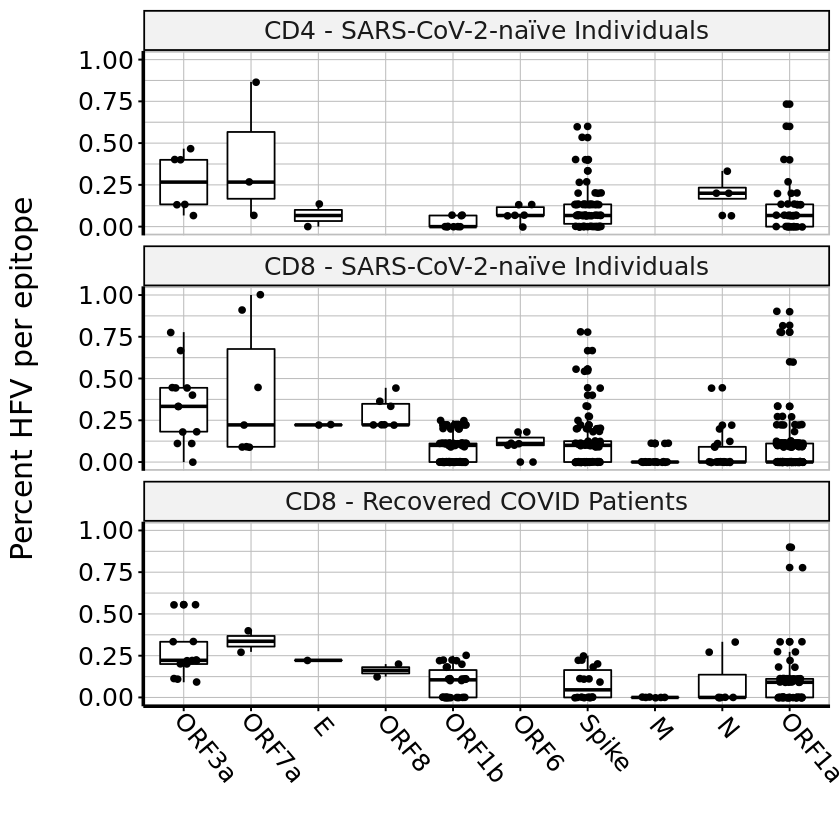

In [22]:
figS4a <- ts1_table_1b %>% 
    mutate(
        intersection_len = intersection_len / sequence_len,
        Gene = factor(
            Gene,
            levels = unique(c(
                "ORF3a", "ORF7a",
                ts1_table_1b %>% 
                mutate(
                    intersection_len = intersection_len / sequence_len
                ) %>%
                group_by(Gene) %>%
                summarise(x = median(intersection_len)) %>%
                arrange(desc(x)) %>% 
                pull(Gene)
            ))
        )
    ) %>%
    ggboxplot(
        x = "Gene",
        y = "intersection_len",
        add = "jitter"
    ) +
    facet_wrap(source~., ncol = 1) +
    labs(
        x = "",
        y = "Percent HFV per epitope\n"
    ) +
    theme( 
        axis.text.x = element_text(size= 15, colour = "black" ,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )

figS4a

Warning message:
“Removed 54 rows containing missing values (geom_bar).”


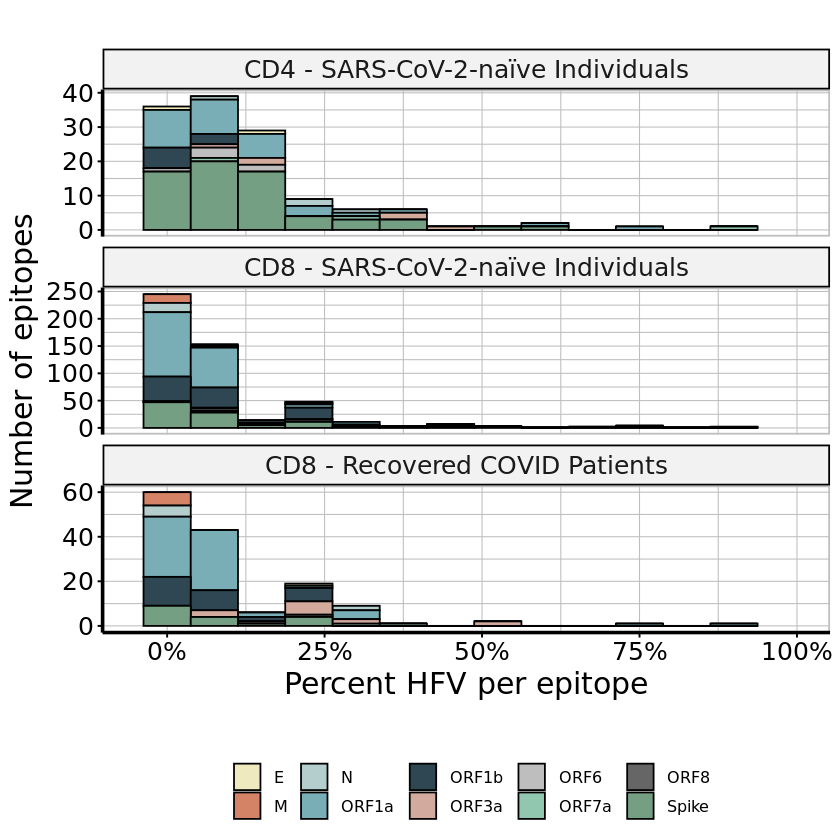

In [23]:
figS4c <- ts1_table_1b %>% 
    mutate(
        intersection_len = intersection_len / sequence_len
    ) %>%
    gghistogram(
        x = "intersection_len" , 
        fill = "Gene",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent HFV per epitope\n", y = "Number of epitopes") +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )  +
    scale_fill_manual(values=rev(c(
        Spike="#749f82",
        ORF1a = "#7aaeb6",
        ORF1b = "#2f4653",                               
        N =  "lightcyan3",
        ORF7a = "#90c7ae", 
        M = "#d48367",
        ORF3a = "#D3AB9E",
        E = "lemonchiffon2",
        ORF6 = "grey",
        ORF8 = "grey40"
    )),name="") +
    facet_wrap(source~., ncol=1, scales = "free_y") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1)) +
    guides(fill = guide_legend(nrow=2))


figS4c

Warning message:
“Removed 54 rows containing missing values (geom_bar).”


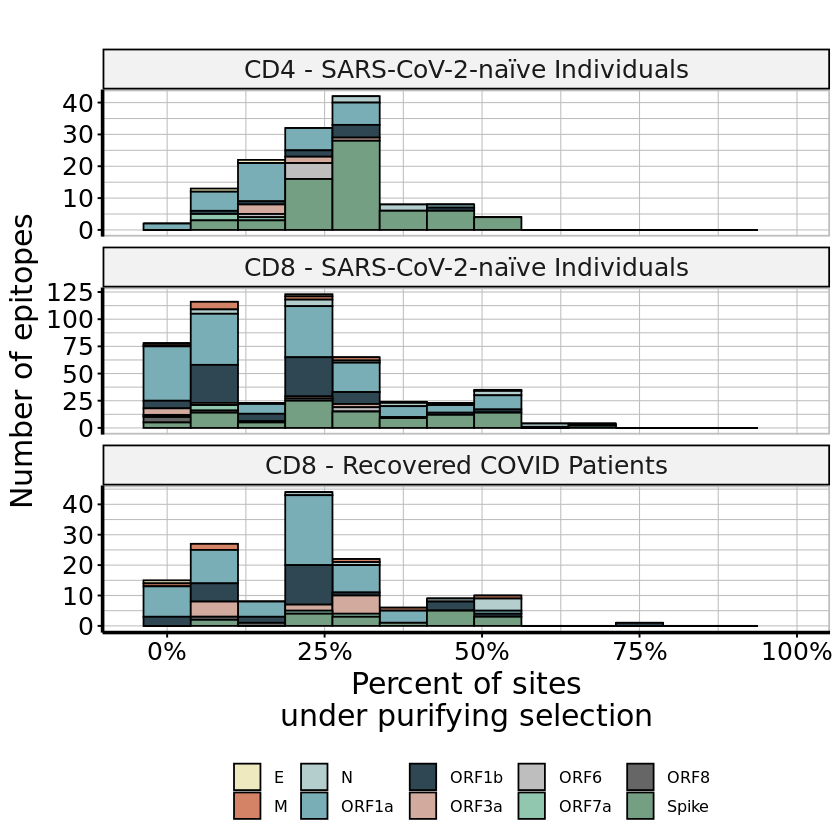

In [24]:
figS4f <- ts1_table_1b %>% 
    mutate(
        Var1 = `Sites Under Purifying Selection` / sequence_len,
    ) %>%
    gghistogram(
        x = "Var1" , 
        fill = "Gene",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent of sites\nunder purifying selection", y = "Number of epitopes") +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )  +
    scale_fill_manual(values=rev(c(
        Spike="#749f82",
        ORF1a = "#7aaeb6",
        ORF1b = "#2f4653",                               
        N =  "lightcyan3",
        ORF7a = "#90c7ae", 
        M = "#d48367",
        ORF3a = "#D3AB9E",
        E = "lemonchiffon2",
        ORF6 = "grey",
        ORF8 = "grey40"
    )),name="") +
    facet_wrap(source~., ncol=1, scales = "free_y") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1)) +
    guides(fill = guide_legend(nrow=2))


figS4f

Warning message:
“Removed 54 rows containing missing values (geom_bar).”


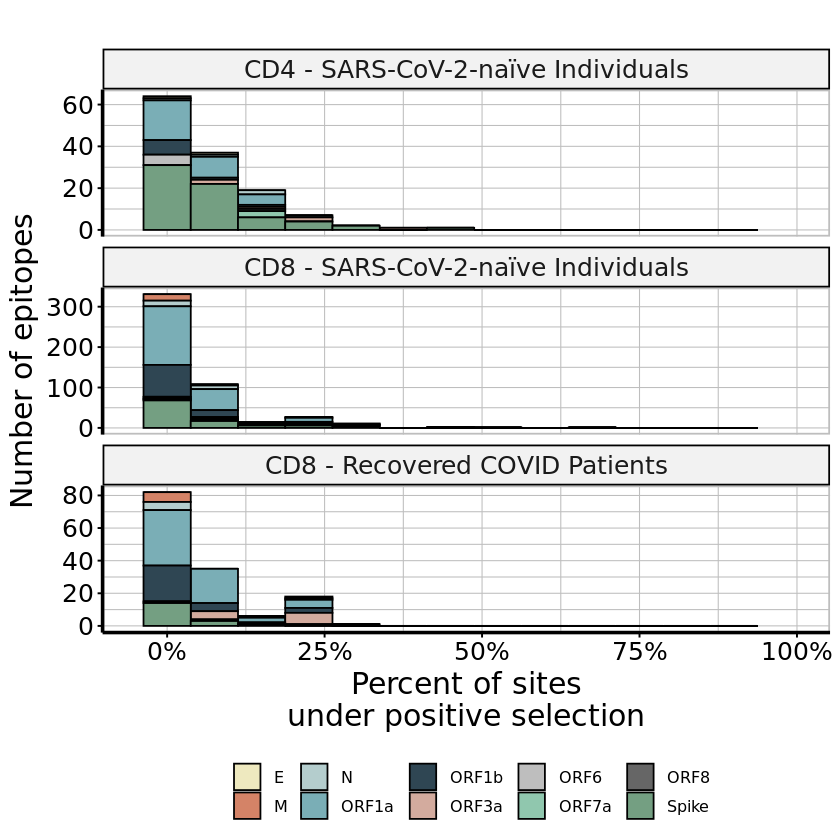

In [25]:
figS4e <- ts1_table_1b %>% 
    mutate(
        Var1 = `Sites Under Diversifying Selection` / sequence_len,
    ) %>%
    gghistogram(
        x = "Var1" , 
        fill = "Gene",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent of sites\nunder positive selection", y = "Number of epitopes") +
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )  +
    scale_fill_manual(values=rev(c(
        Spike="#749f82",
        ORF1a = "#7aaeb6",
        ORF1b = "#2f4653",                               
        N =  "lightcyan3",
        ORF7a = "#90c7ae", 
        M = "#d48367",
        ORF3a = "#D3AB9E",
        E = "lemonchiffon2",
        ORF6 = "grey",
        ORF8 = "grey40"
    )),name="") +
    facet_wrap(source~., ncol=1, scales = "free_y") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1)) +
    guides(fill = guide_legend(nrow=2))


figS4e

Warning message:
“Removed 12 rows containing missing values (geom_bar).”


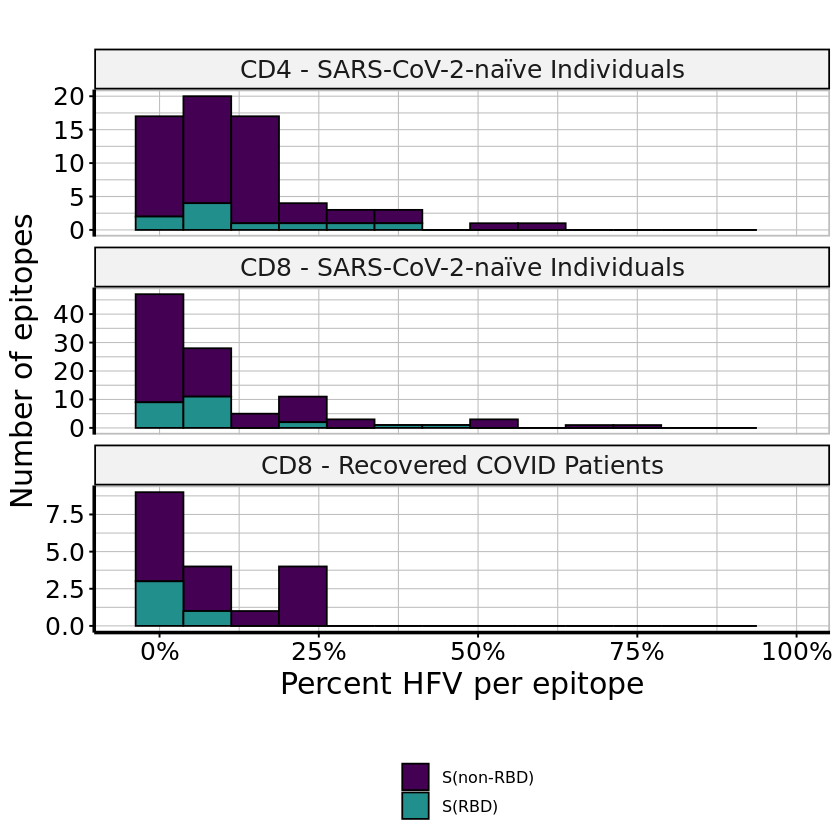

In [26]:
py <- seq( 0 , 40, 5 )

figS4d <- ts1_table_1b %>% 
    filter(Gene == "Spike") %>%
    mutate(
        Protein = case_when(
            Gene == "Spike" & gene_start >= 319 & gene_stop <= 541 ~ "S(RBD)",
            Gene == "Spike" ~ "S(non-RBD)"
        ),
        intersection_len = intersection_len / sequence_len
    ) %>%
    gghistogram(
        x = "intersection_len" , 
        fill = "Protein",
        binwidth = 0.075,
        color = "black", 
        position = "stack",
        alpha = 1
    )  +
    labs(title = "", x = "Percent HFV per epitope\n ", y = "Number of epitopes") +
    scale_fill_manual(values=viridisLite::viridis(3),name="") + 
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position="bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    )+
    facet_wrap(source~., ncol=1, scales = "free_y") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1)) +
    guides(fill = guide_legend(nrow=2))

figS4d

Warning message:
“Removed 9 rows containing missing values (geom_bar).”


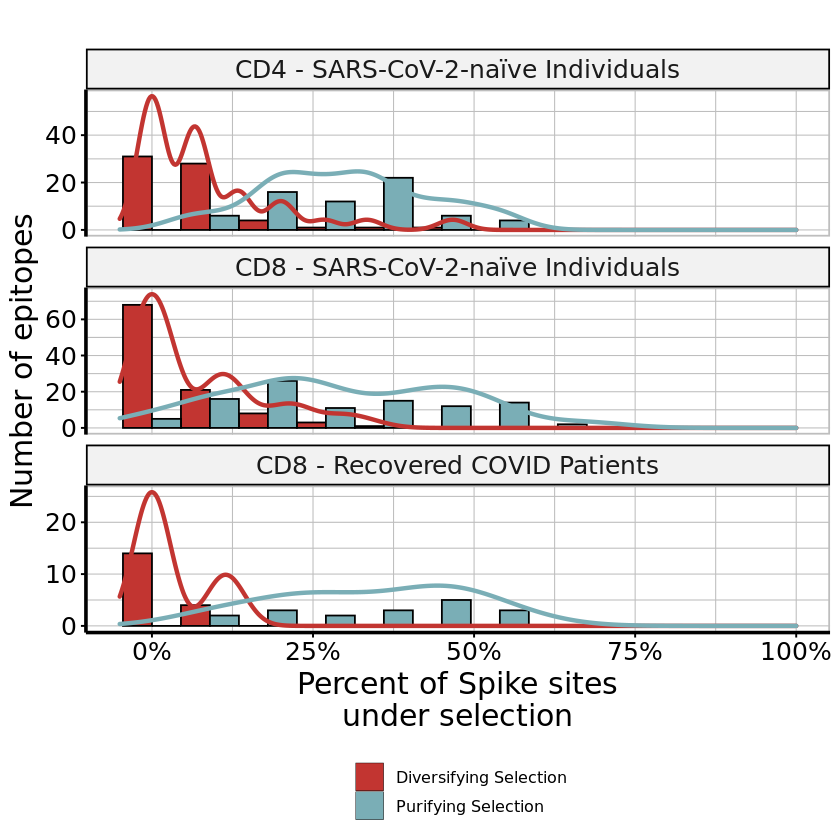

In [27]:
figS4g <- rbind(
    ts1_table_1b %>%
        filter(Gene == "Spike") %>%
        mutate(
            Var1 = `Sites Under Diversifying Selection` / sequence_len,
            Type = "Diversifying Selection"
        ),
    ts1_table_1b %>%
        filter(Gene == "Spike") %>%
        mutate(
            Var1 = `Sites Under Purifying Selection` / sequence_len,
            Type = "Purifying Selection"
        )
    ) %>%
    mutate(
        Type = factor(Type, levels = (c("Diversifying Selection", "Purifying Selection")))
    ) %>%
    gghistogram(
        x = "Var1" , 
        fill = "Type",
        binwidth = 0.09,
        color = "black", 
        position = "dodge", 
        alpha = 1
    )  +
    geom_density(
        aes(y = ..count..^.75 / 2.25, color = Type),
        size = 1.25
    ) +
    labs(title = "", x = "Percent of Spike sites\nunder selection", y = "Number of epitopes") +
    scale_color_manual(values=rev(c("#7aaeb6","#c23531")),name="") + 
    scale_fill_manual(values=rev(c("#7aaeb6","#c23531")),name="") + 
    theme( 
        axis.text.x = element_text( size= 15, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 15, colour = "black"),
        axis.title.y = element_text(size = 18),
        axis.title.x = element_text(size = 18),
        axis.line.x = element_line(colour = "black", size = 1),
        axis.line.y = element_line(colour = "black", size = 1),

        legend.position = "bottom",

        panel.grid.major = element_line(colour = "grey", size=0.3),
        panel.grid.minor = element_line(colour = "grey", size=0.3),

        title = element_text(size = 15), 
        strip.text.x = element_text(size = 15), 
        strip.background = element_rect(color = "black", size = 1),
        
        panel.background = element_rect(fill = "white"),
        panel.border = element_rect(fill =NA, colour = "grey", size = 1)
    ) +
    facet_wrap(source~., ncol=1, scales = "free_y") +
    scale_x_continuous(labels = scales::percent, limits = c(-0.05,1)) +
    guides(fill = guide_legend(nrow=2), color = guide_legend(nrow=2))

figS4g